📁 Analizando colección: apartment


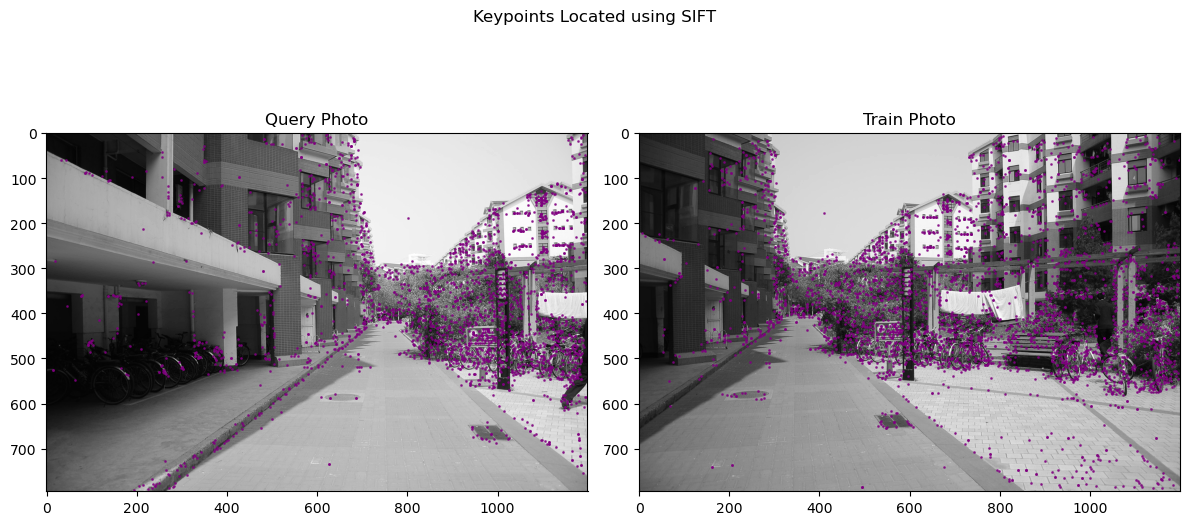

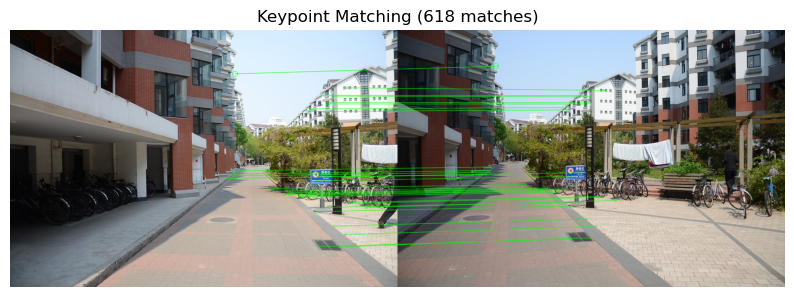

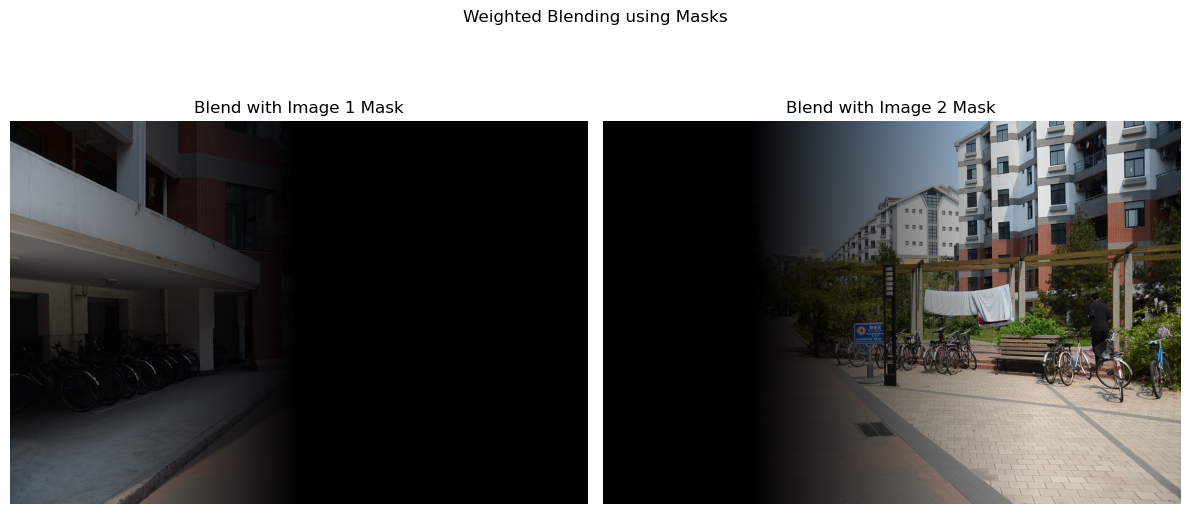

📁 Analizando colección: complex


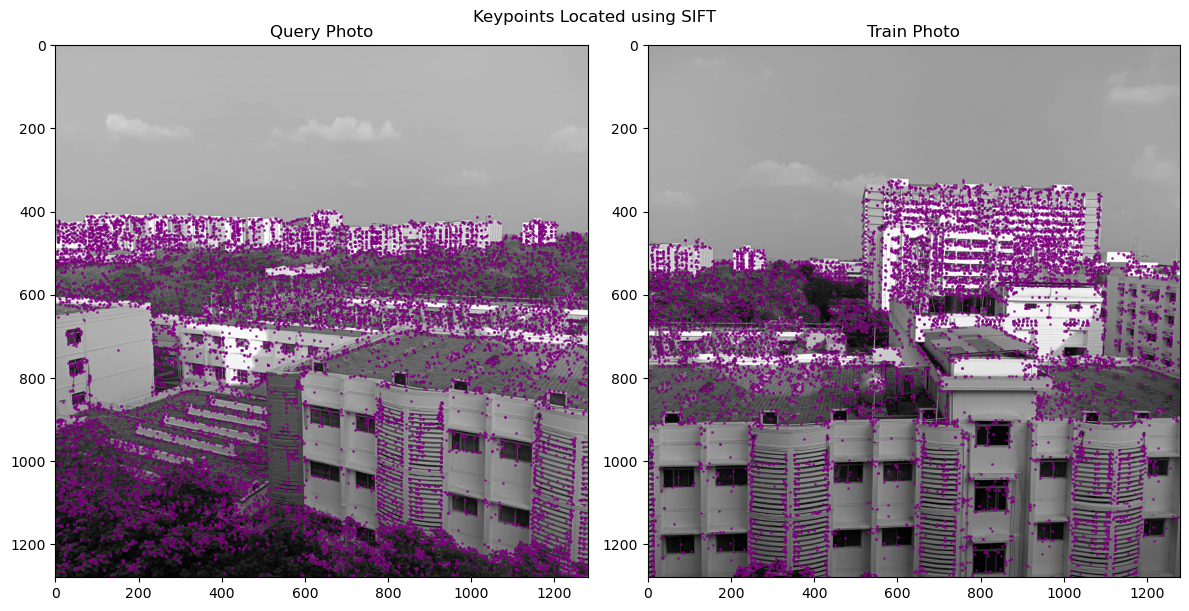

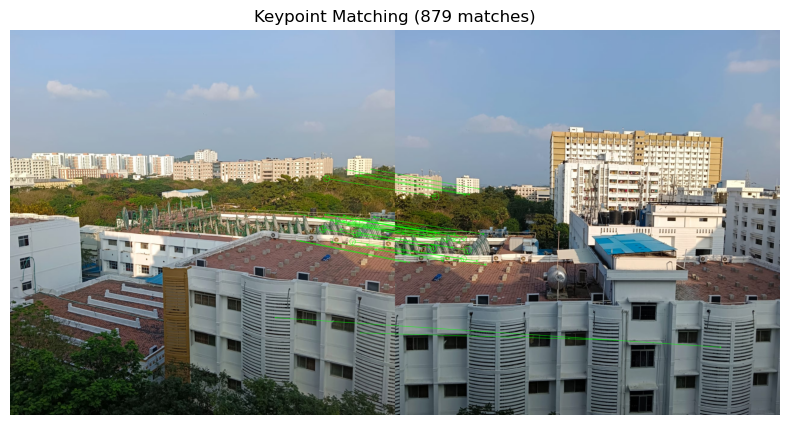

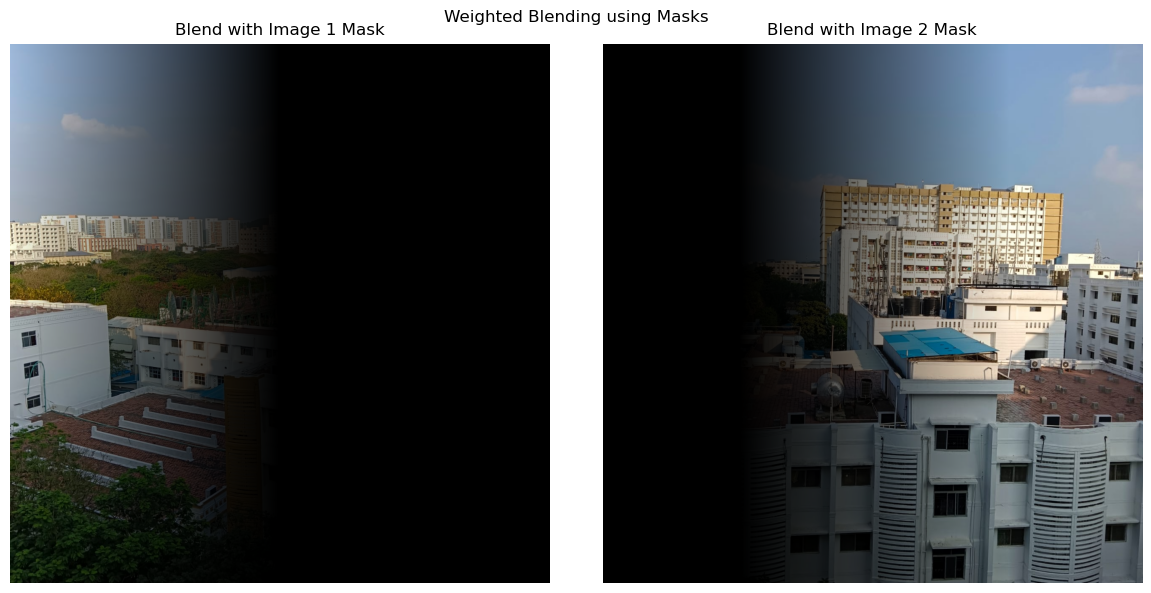

📁 Analizando colección: field


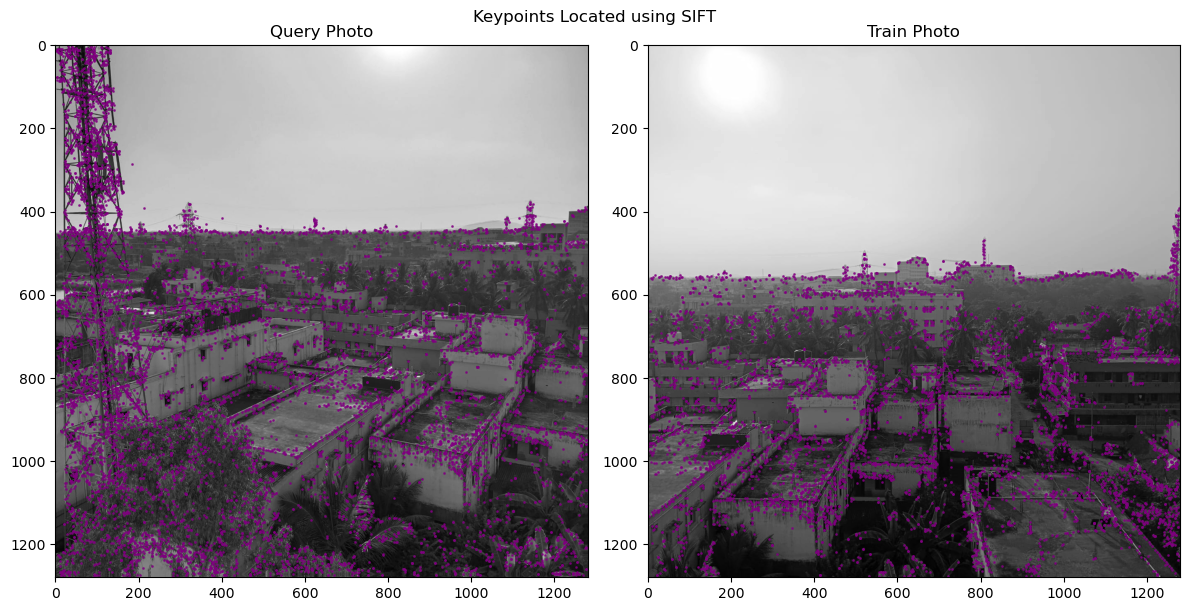

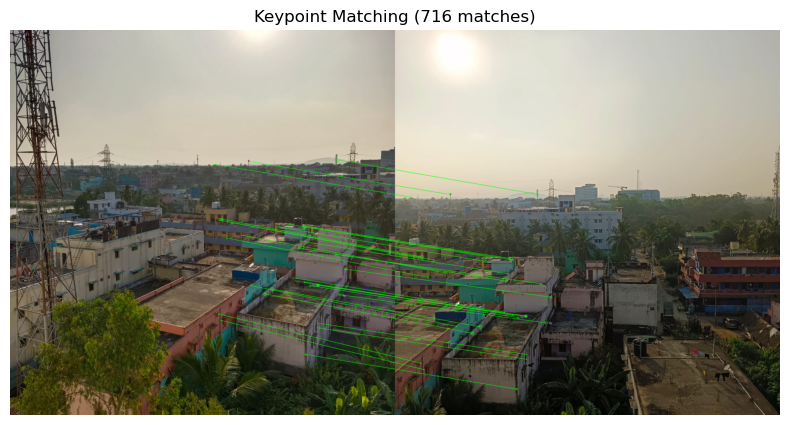

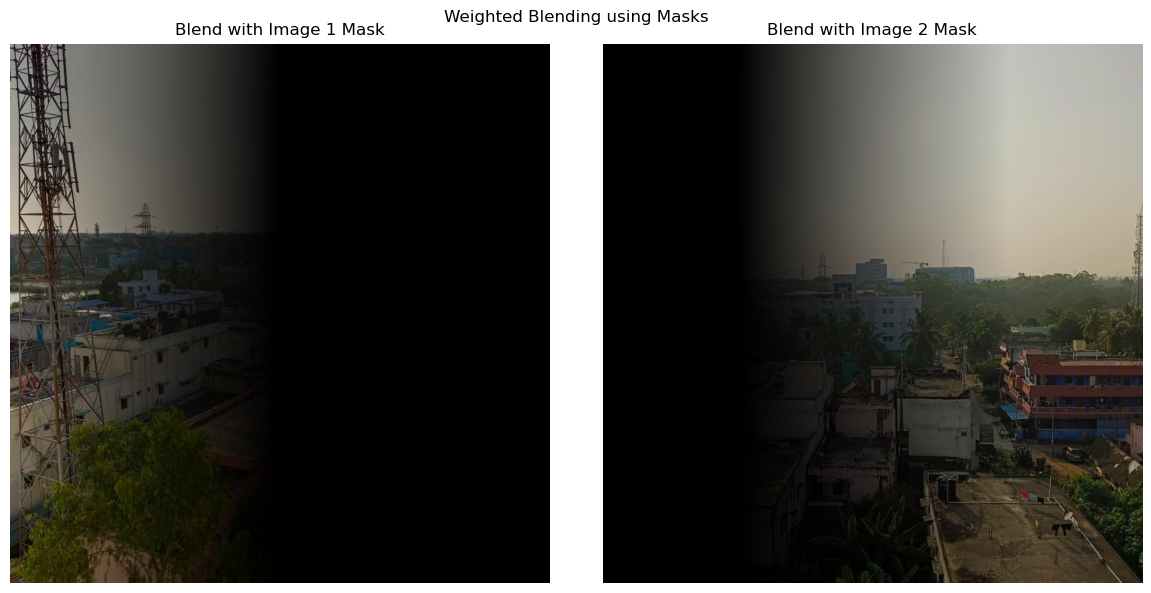

📁 Analizando colección: flower


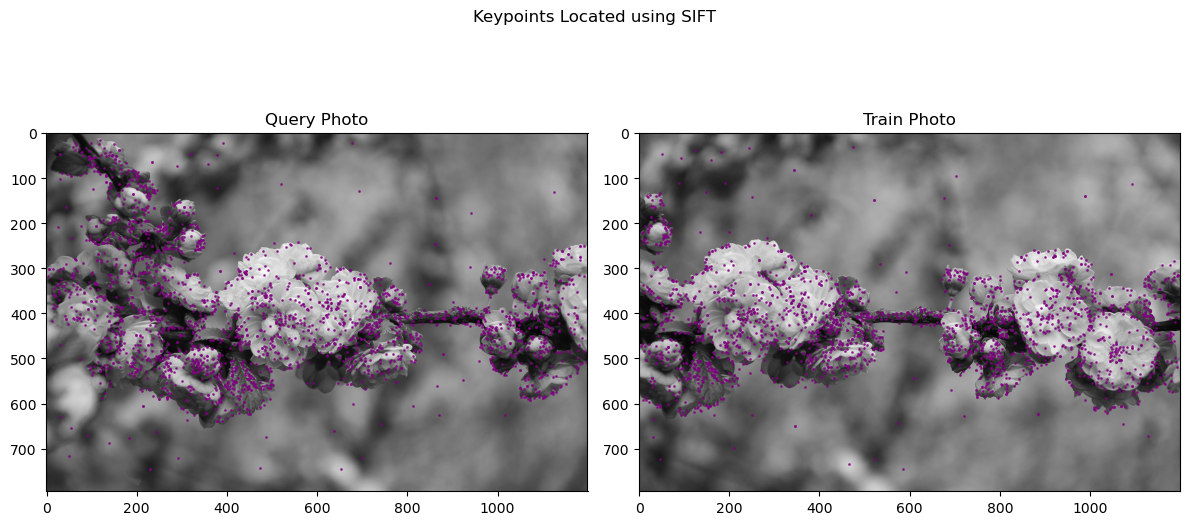

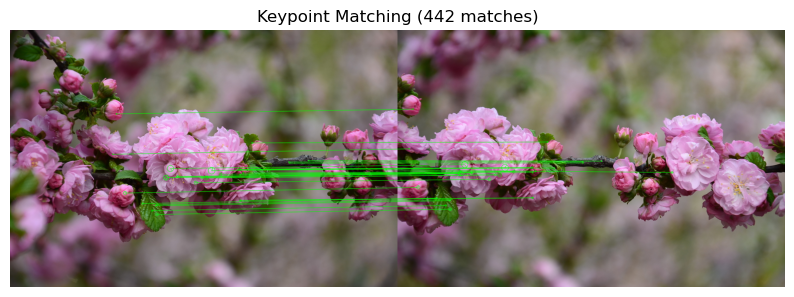

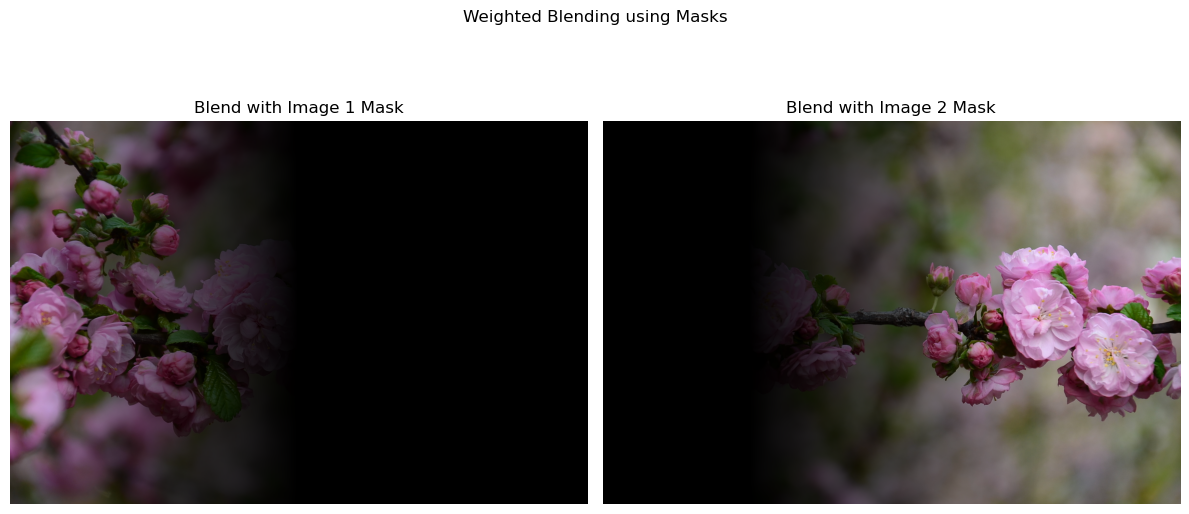

📁 Analizando colección: sunrise


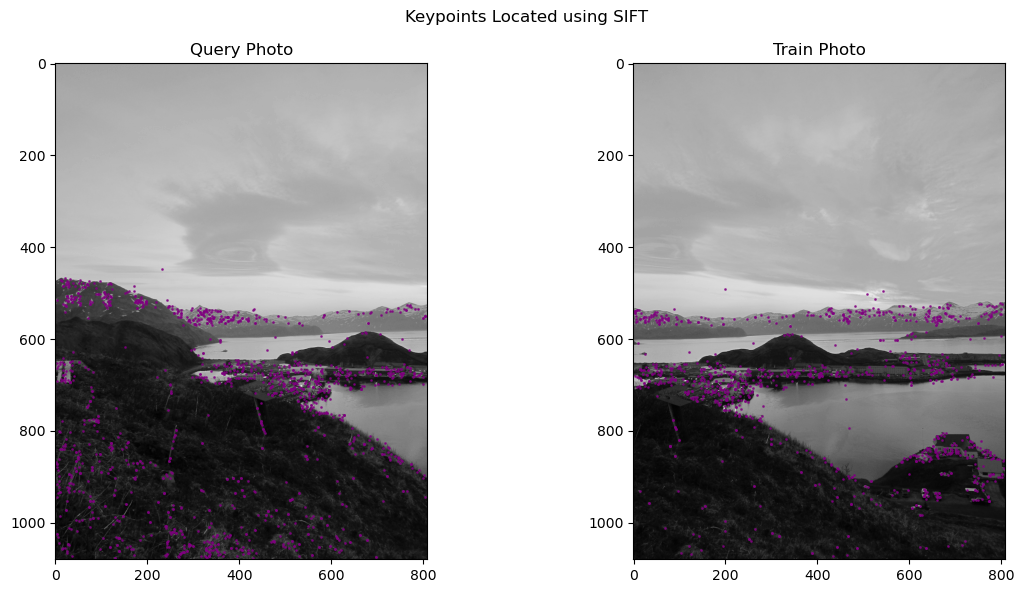

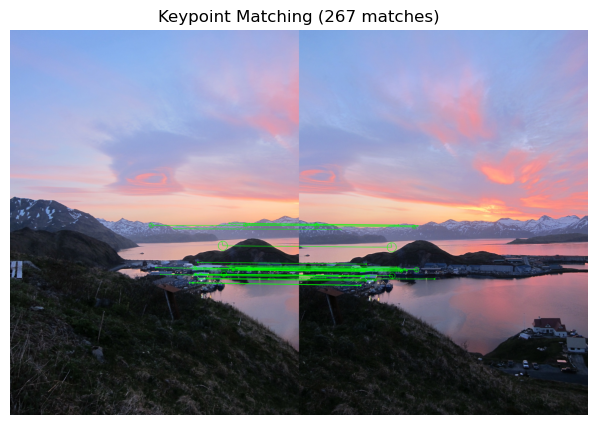

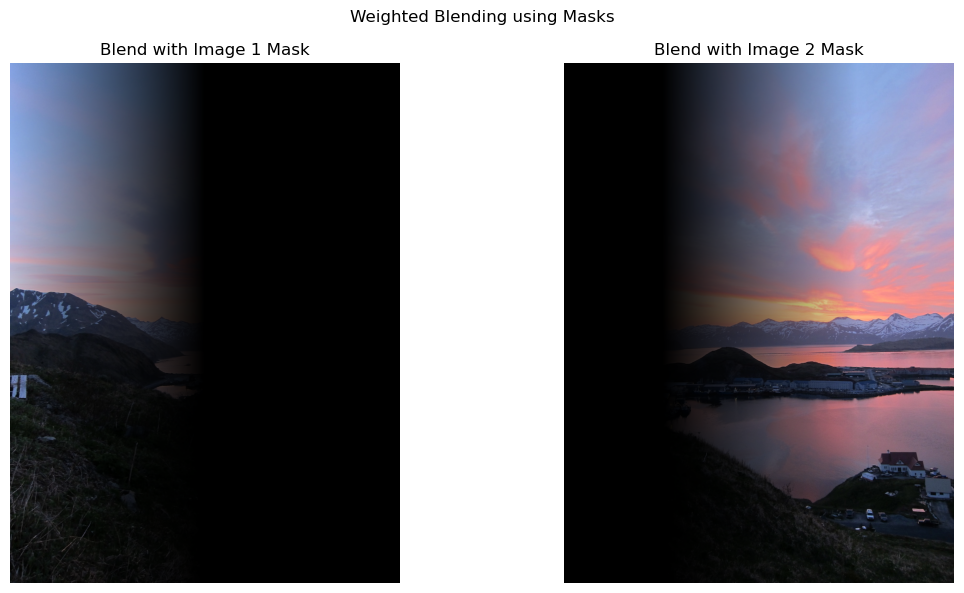

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

base_path = "../data/input"
collections = ["apartment", "complex", "field", "flower", "sunrise"]

def show_sift_keypoints(img1, img2, kp1, kp2, title="Keypoints Located using SIFT"):
    """Display SIFT keypoints in purple on grayscale images side by side"""
    plt.figure(figsize=(12, 6))
    
    # Convert to grayscale if needed
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        gray1 = img1.copy()
    
    if len(img2.shape) == 3:
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        gray2 = img2.copy()
    
    # Create subplots
    plt.subplot(1, 2, 1)
    plt.imshow(gray1, cmap='gray')
    plt.scatter([kp.pt[0] for kp in kp1], [kp.pt[1] for kp in kp1], s=1, c='purple', alpha=0.7)
    plt.title("Query Photo")
    # Removed invert_yaxis to fix the upside down issue
    
    plt.subplot(1, 2, 2)
    plt.imshow(gray2, cmap='gray')
    plt.scatter([kp.pt[0] for kp in kp2], [kp.pt[1] for kp in kp2], s=1, c='purple', alpha=0.7)
    plt.title("Train Photo")
    # Removed invert_yaxis to fix the upside down issue
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_weighted_blending(img1, img2, title="Weighted Blending using Masks"):
    """Show weighted blending between two images using proper masks"""
    # Get image dimensions (assuming both are same size)
    h, w = img1.shape[:2]
    
    # Create masks for blending
    mask1 = np.zeros((h, w), dtype=np.float32)
    mask2 = np.zeros((h, w), dtype=np.float32)
    
    # Create gradual fade from left to right for image 1
    for i in range(w):
        mask1[:, i] = max(0, 1 - (i / (w * 0.5)))
    
    # Create gradual fade from right to left for image 2
    for i in range(w):
        mask2[:, i] = max(0, (i / (w * 0.5)) - 0.5)
    
    # Ensure mask values are between 0 and 1
    mask1 = np.clip(mask1, 0, 1)
    mask2 = np.clip(mask2, 0, 1)
    
    # Create blank canvas for blended image
    blended1 = np.zeros_like(img1, dtype=np.float32)
    blended2 = np.zeros_like(img2, dtype=np.float32)
    
    # Apply masks
    for c in range(3):  # Apply to each channel
        blended1[..., c] = img1[..., c] * mask1
        blended2[..., c] = img2[..., c] * mask2
    
    # Convert back to uint8
    blended1 = blended1.astype(np.uint8)
    blended2 = blended2.astype(np.uint8)
    
    # Display the results in color
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(blended1, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct color display
    plt.title("Blend with Image 1 Mask")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(blended2, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct color display
    plt.title("Blend with Image 2 Mask")
    plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_image(img, title='', cmap=None):
    plt.figure(figsize=(10, 5))
    # Convert BGR to RGB for color images
    if len(img.shape) == 3 and img.shape[2] == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main script execution
for collection in collections:
    print(f"📁 Analizando colección: {collection}")
    folder_path = os.path.join(base_path, collection)
    files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))])
    
    if len(files) < 2:
        print("⚠️ No hay suficientes imágenes.")
        continue
    
    # Tomar las dos primeras imágenes
    path1 = os.path.join(folder_path, files[0])
    path2 = os.path.join(folder_path, files[1])
    
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Crear detector SIFT
    sift = cv2.SIFT_create()
    
    # SIFT Keypoints
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    # Display SIFT keypoints in the style shown in the reference image
    show_sift_keypoints(gray1, gray2, kp1, kp2, f"Keypoints Located using SIFT")
    
    # Improved Keypoint Matching
    # Use FLANN matcher instead of BF for better performance with SIFT
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors using FLANN
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply stricter ratio test to filter better matches
    good = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:  # Stricter ratio test (0.6 instead of 0.75)
            good.append(m)
    
    # Sort matches by distance for better visualization
    good = sorted(good, key=lambda x: x.distance)
    
    # Only draw good matches and limit to top 30 for cleaner visualization
    match_limit = min(30, len(good))
    match_img = cv2.drawMatches(
        img1, kp1, 
        img2, kp2, 
        good[:match_limit], None, 
        matchColor=(0, 255, 0),  # Green color for matches
        singlePointColor=None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS + cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS
    )
    
    show_image(match_img, f'Keypoint Matching ({len(good)} matches)')
    
    # Apply weighted blending with masks
    show_weighted_blending(img1, img2, f"Weighted Blending using Masks")